# Prepare Data

In [16]:
from google.colab import files
from google.colab import drive

from keras.models import Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Input, Softmax
from keras.engine.saving import model_from_json
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import os
import sys

import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt

import librosa
import librosa.display

import tensorflow as tf

print(tf.__version__)

2.4.0


In [2]:
drive.mount('/content/gdrive', force_remount=True)
iemocap = "gdrive/My Drive/Public/IEMOCAP_full_release"

Mounted at /content/gdrive


# Convert into CSV

In [3]:
sessions = ["Session1", "Session2", "Session3", "Session4", "Session5"]

def convertSession(session_name):
  session_file = iemocap + "/Duration/Processed/" + session_name + ".txt"
  tokenized_lines = []

  with open(session_file) as f:
    lines = f.readlines()
    tokenizedLines = [x.split() for x in lines]

  session_csv = iemocap + "/Duration/Processed/" + session_name + ".csv"
  with open(session_csv, "w") as csv:
    audio_name = ''

    for line in tokenizedLines:
      if line[0] == "Recording":
        audio_name = line[1]
      else:
        csv.write(audio_name + ";" + line[0] + ";" + line[1] + "\n")

def convertRawToCsv():
  for session in sessions:
    convertSession(session)

# convertRawToCsv()

# Convert into data frame

In [4]:
def getSessionData(session_name):
  df = pd.read_csv(iemocap + "/Duration/Processed/" + session_name + ".csv", delimiter=";", header=None)
  df.columns = ["Audio Name", "Part", "Duration"]
  print(session_name + " count: " + str(len(df.index)))

  return df

def getDataFrame():
  result = pd.DataFrame()

  for session in sessions:
    df = getSessionData(session)
    result = result.append(df, ignore_index=True)

  return result

result = getDataFrame()
result["Duration"] = result["Duration"].apply(np.floor).astype(int)
result

Session1 count: 1819
Session2 count: 1811
Session3 count: 2136
Session4 count: 2103
Session5 count: 2170


,Audio Name,Part,Duration
0,Ses01F_impro01,F000,1
1,Ses01F_impro01,F001,1
2,Ses01F_impro01,F002,3
3,Ses01F_impro01,F003,1
4,Ses01F_impro01,F004,3
...,...,...,...
10034,Ses05M_script03_2,M041,8
10035,Ses05M_script03_2,M042,1
10036,Ses05M_script03_2,M043,2
10037,Ses05M_script03_2,M044,4


# Plot

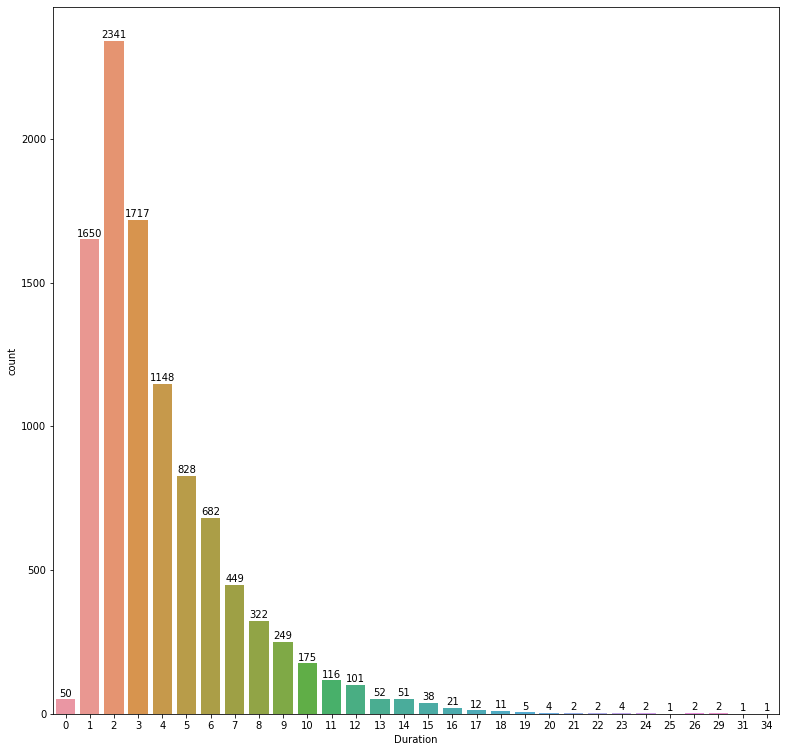

In [ ]:
plot = seaborn.countplot(x='Duration', data=result)
plot.figure.set_size_inches(13,13)

for p in plot.patches:
  height = p.get_height()
  plot.text(p.get_x() + p.get_width()/2., height + 10, '{:1.0f}'.format(height), ha="center") 

In [ ]:
print("Original data: " + str(result.count()))

count_data = result.value_counts(subset=['Duration'], sort=False).values
count_normalize = result.value_counts(subset=['Duration'], sort=False, normalize=True).values
duration = sorted(result.Duration.unique())

count_df = pd.DataFrame({"Duration": duration, "Count": count_data, "Percentage": count_normalize})
count_df.Percentage = (count_df.Percentage * 100).round(3)
count_df

Original data: Audio Name     10039
Part           10039
Duration       10039
Evaluation1        0
Evaluation2        0
Evaluation3        0
Evaluation4        0
Evaluation5        0
Evaluation6        0
Emotion        10039
dtype: int64


,Duration,Count,Percentage
0,0,50,0.498
1,1,1650,16.436
2,2,2341,23.319
3,3,1717,17.103
4,4,1148,11.435
5,5,828,8.248
6,6,682,6.794
7,7,449,4.473
8,8,322,3.207
9,9,249,2.480


# Labeling

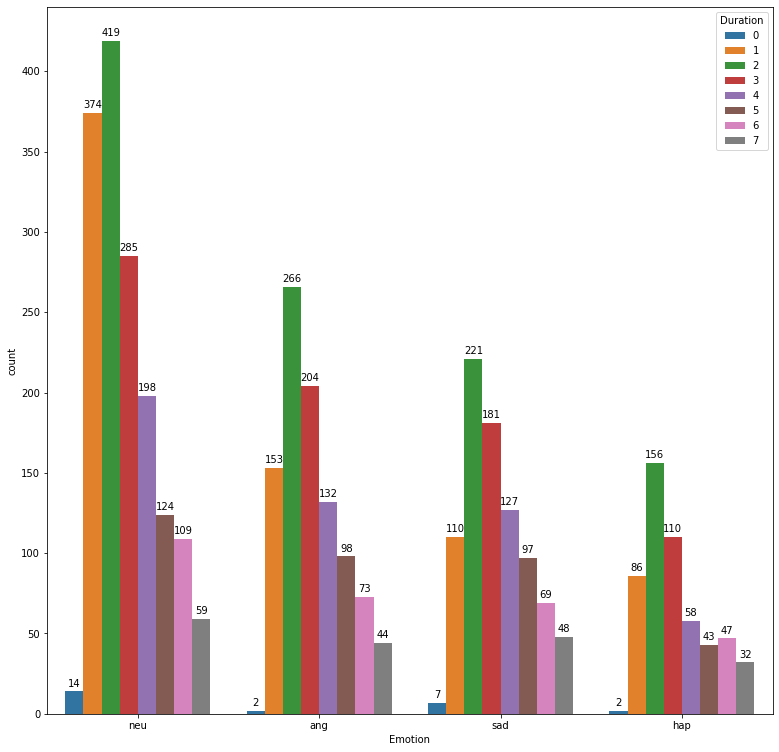

In [5]:
def resetEvaluation():
  # TODO Relabel
  # emotion_column = ["Evaluation1", "Evaluation2", "Evaluation3", "Evaluation4", "Evaluation5", "Evaluation6"]

  # for column in emotion_column:
  #   result[column] = None

  result["Emotion"] = None

def goLabeling():
  for session in sessions:
    emotion_path = iemocap + "/" + session + "/dialog/EmoEvaluation/"

    recordings = [file.name for file in os.scandir(emotion_path) if ".txt" in file.name]
    recordings.sort()
    
    for recording in recordings:
      with open(emotion_path + recording) as f:
        lines = f.readlines()
        tokenizedLines = [x.split() for x in lines if "Ses0" in x]

        for part in tokenizedLines:
          line_name = part[3]
          line_label = part[4]
          line_queries = line_name.split("_")
          
          line_part = line_queries[-1]
          line_queries.remove(line_part)

          line_name = "_".join(line_queries)

          search_query_name = ""
          search_query_part = line_queries[-1]
          search_result = result.loc[(result["Audio Name"] == line_name) & (result["Part"] == line_part), "Emotion"]
          search_count = search_result.shape[0]
          
          if search_count == 0:
            print("ERROR: No audio part found: ")
          elif search_count > 1:
            print("ERROR: Multiple audio found: ")
          else:
            result.loc[(result["Audio Name"] == line_name) & (result["Part"] == line_part), "Emotion"] = line_label

def getClassificationReport():
  max_duration = 7

  categorical_data = result.loc[
    (result["Duration"] < max_duration + 1) &
    (
      (result["Emotion"] == 'neu') |
      (result["Emotion"] == 'ang') |
      (result["Emotion"] == 'hap') |
      (result["Emotion"] == 'sad') 
    )
  ]
  
  categorical_plot = seaborn.countplot(x="Emotion", hue="Duration", data=categorical_data)
  categorical_plot.figure.set_size_inches(13,13)

  for p in categorical_plot.patches:
    height = p.get_height()
    categorical_plot.text(p.get_x() + p.get_width()/2., height + 3, '{:1.0f}'.format(height), ha="center") 

  return categorical_data

resetEvaluation()
goLabeling()
categorical_data = getClassificationReport()

# Selection and Splitting

In [6]:
def checkAndCreateDirectory(filename):
  if not os.path.exists(os.path.dirname(filename)):
    try:
        os.makedirs(os.path.dirname(filename))
    except OSError as exc: # Guard against race condition
        print(exc.errno)
        if exc.errno != errno.EEXIST:
            raise

def getMfccValue(audio_path):
  audio_file, sample_rate = librosa.load(audio_path)
  S = librosa.feature.melspectrogram(y=audio_file, sr=sample_rate)

  return S

def getEncodedLabel(label):
  label_hot = [0, 0, 0, 0]
  
  if    (label == "neu"): label_hot = [1, 0, 0, 0]
  elif  (label == "ang"): label_hot = [0, 1, 0, 0]
  elif  (label == "hap"): label_hot = [0, 0, 1, 0]
  elif  (label == "sad"): label_hot = [0, 0, 0, 1]

  np.where(np.array(label_hot) == 1)[0][0]
  return np.array(label_hot)

def getAudioPath(row):
  audio_prefix = row["Audio Name"][:5]
  audio_session = "Error"

  if    (audio_prefix == 'Ses01'): audio_session = "Session1"
  elif  (audio_prefix == 'Ses02'): audio_session = "Session2"
  elif  (audio_prefix == 'Ses03'): audio_session = "Session3"
  elif  (audio_prefix == 'Ses04'): audio_session = "Session4"
  elif  (audio_prefix == 'Ses05'): audio_session = "Session5"

  audio_path = iemocap + '/' + audio_session + '/sentences/wav/' + row["Audio Name"] + '/' + row["Audio Name"] + '_' + row["Part"] + '.wav'
  return audio_path

def getVectorAudio(base_duration, durationed_data):
  X = [] # Data
  Y = [] # Label

  durationed_length = len(durationed_data)

  # Iterate every data
  for index, row in durationed_data.iterrows():
    print("Saving " + str(durationed_length) + " " + str(index), end=" | ")

    if durationed_length % 10 == 0: print("\n")
    durationed_length -= 1

    # Get Label
    label = row["Emotion"]
    label_hot = getEncodedLabel(label)

    # Get Mfcc
    audio_path = getAudioPath(row)
    mfcc = getMfccValue(audio_path)
    mfcc_length = mfcc.shape[1]

    mfcc_slice = 50 * base_duration

    # Add all slices to X
    # TODO add more data and paddings
    # TODO ERROR in padding because random and became inbalance
    # TODO Scaling

    #   mfcc = np.pad(mfcc, pad_width=((0, 0), (0, ((50 * duration) - mfcc_length))), mode='constant')

    for mfcc_partial in range(int(mfcc_length/mfcc_slice)):
      start = mfcc_partial * mfcc_slice
      end = (mfcc_partial + 1) * mfcc_slice

      mfcc_partial_result = mfcc[:,start:end]

      if (mfcc_partial_result.shape[1] != mfcc_slice) | (mfcc_partial_result.shape[0] != 128):
        print("ERROR Mfcc " + index + row)
        break
      
      X.append(mfcc_partial_result)
      Y.append(label_hot)

  return np.array(X), np.array(Y)

def testDuration():
  audio_file, sample_rate = librosa.load('/content/gdrive/My Drive/Public/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M008.wav')
  duration = librosa.get_duration(y=audio_file, sr=sample_rate)
  print(duration)

  S = librosa.feature.mfcc(y=audio_file, sr=48000)
  print(S.shape)

def getEmotionSplitting(base_duration, max_duration):
  train_data    = pd.DataFrame()
  val_data      = pd.DataFrame()
  test_data     = pd.DataFrame()

  for iterate_index in range(base_duration, max_duration + 1):
    print(iterate_index)
    neutral_duration = result.loc[
      (result["Duration"] == iterate_index) &
      (result["Emotion"]  == 'neu')
    ]

    angry_duration = result.loc[
      (result["Duration"] == iterate_index) &
      (result["Emotion"]  == 'ang')
    ]

    sad_duration = result.loc[
      (result["Duration"] == iterate_index) &
      (result["Emotion"]  == 'sad')
    ]

    happy_duration = result.loc[
      (result["Duration"] == iterate_index) &
      (result["Emotion"]  == 'hap')
    ]

    sample_lowest = min(neutral_duration.shape[0], angry_duration.shape[0], sad_duration.shape[0], happy_duration.shape[0])

    neutral_duration  = neutral_duration.sample(sample_lowest)
    angry_duration    = angry_duration.sample(sample_lowest)
    sad_duration      = sad_duration.sample(sample_lowest)
    happy_duration    = happy_duration.sample(sample_lowest)

    # Splitting
    # 0,6 : 0,8 : 1,0 (60%, 20%, 20%)
    data_training_percent   = int(0.6 * sample_lowest)
    data_validation_percent = int(0.8 * sample_lowest)

    train_data = train_data.append(neutral_duration [:data_training_percent])
    train_data = train_data.append(angry_duration   [:data_training_percent])
    train_data = train_data.append(sad_duration     [:data_training_percent])
    train_data = train_data.append(happy_duration   [:data_training_percent])

    val_data = val_data.append(neutral_duration   [data_training_percent:data_validation_percent])
    val_data = val_data.append(angry_duration     [data_training_percent:data_validation_percent])
    val_data = val_data.append(sad_duration       [data_training_percent:data_validation_percent])
    val_data = val_data.append(happy_duration     [data_training_percent:data_validation_percent])

    test_data = test_data.append(neutral_duration     [data_validation_percent:sample_lowest])
    test_data = test_data.append(angry_duration       [data_validation_percent:sample_lowest])
    test_data = test_data.append(sad_duration         [data_validation_percent:sample_lowest])
    test_data = test_data.append(happy_duration       [data_validation_percent:sample_lowest])

  return train_data.sample(frac=1), val_data.sample(frac=1), test_data.sample(frac=1)

base_duration = 1
max_duration = 1

train_data, val_data, test_data = getEmotionSplitting(base_duration, max_duration)

x_train, y_train  = getVectorAudio(base_duration, train_data)
x_val, y_val      = getVectorAudio(base_duration, val_data)
x_test, y_test    = getVectorAudio(base_duration, test_data)

1
Saving 204 2336 | Saving 203 7824 | Saving 202 2040 | Saving 201 8479 | Saving 200 4513 | 

Saving 199 6110 | Saving 198 6569 | Saving 197 4990 | Saving 196 3107 | Saving 195 4911 | Saving 194 6832 | Saving 193 260 | Saving 192 8486 | Saving 191 215 | Saving 190 8356 | 

Saving 189 4893 | Saving 188 3099 | Saving 187 1203 | Saving 186 9118 | Saving 185 516 | Saving 184 7887 | Saving 183 5985 | Saving 182 2492 | Saving 181 2834 | Saving 180 8126 | 

Saving 179 3946 | Saving 178 2377 | Saving 177 7168 | Saving 176 9107 | Saving 175 2502 | Saving 174 3318 | Saving 173 8030 | Saving 172 2128 | Saving 171 6839 | Saving 170 477 | 

Saving 169 4812 | Saving 168 9365 | Saving 167 8992 | Saving 166 3553 | Saving 165 2761 | Saving 164 2478 | Saving 163 3426 | Saving 162 9992 | Saving 161 6257 | Saving 160 7038 | 

Saving 159 992 | Saving 158 7470 | Saving 157 2991 | Saving 156 2702 | Saving 155 7832 | Saving 154 7657 | Saving 153 4179 | Saving 152 4678 | Saving 151 3428 | Saving 150 8212 | 

S

In [7]:
def plot_result(model, history):
  # list all data in history
  print(history.history.keys())

  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

def save_model(model, filename):
  checkAndCreateDirectory("model/test.txt")
  model.summary()

  plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

  with open("model/" + filename + ".json", "w") as json_file:
    model_json = model.to_json()
    json_file.write(model_json)

def buildModel():
  model_input = Input(shape=(128, 50, 1))

  # model = Conv2D(64, kernel_size=3, strides=2)(model)

  model = Conv2D(256, 16)(model_input)
  # model = Dropout(0.1)(model)
  model = Conv2D(256, 16)(model)
  # model = Dropout(0.1)(model)
  model = Conv2D(256, 16)(model)
  # model = Dropout(0.1)(model)

  model = Flatten()(model)
  # model = Dropout(0.1)(model)

  model = Dense(256)(model)
  # model = Dropout(0.1)(model)
  
  model = Dense(4, activation='softmax')(model)
  
  # Model compile
  model = Model(inputs=[model_input], outputs=[model])
  model.compile(optimizer="adam", loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["accuracy"])
  
  # Visualize & Save Model
  save_model(model, "struct_model")

  # Checkpoint
  basepath = '/content/model/weight_model'
  best_checkpoint = ModelCheckpoint(basepath +'_{epoch:02d}_{loss:.2f}_{accuracy:.2f}_{val_loss:.2f}_{val_accuracy:.2f}.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max', period=1)
  callback_list = [best_checkpoint]

  history = model.fit(
    x_train, 
    y_train, 
    validation_data=(x_val, y_val),
    batch_size=5, 
    epochs=1000,
    callbacks=callback_list
  )

  return model, history

!rm -rf /content/model
model, history = buildModel()
plot_result(model, history)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 50, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 113, 35, 256)      65792     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 98, 20, 256)       16777472  
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 83, 5, 256)        16777472  
_________________________________________________________________
flatten (Flatten)            (None, 106240)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               27197696  
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028  

KeyboardInterrupt: ignored

# Testing

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)
print(
    ""
    "Prediction Loss: %2d\n"
    "Prediction Accuracy: %2d%%"
    ""
    % (loss, accuracy * 100))

3/3 [==============================] - 0s 5ms/step - loss: 71399.2031 - accuracy: 0.3182
Prediction Loss: 71399
Prediction Accuracy: 31%


# Analysis

In [ ]:
target_names = ['neu', 'ang', 'hap', "sad"]

Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)

y_decoded = []
for pred in y_test:
  decoded = np.where(pred == 1)[0][0]
  y_decoded.append(decoded)

print('Confusion Matrix')
print(target_names)
print(confusion_matrix(y_decoded, y_pred))
print(x_test.shape)

print('\n\nClassification Report')
print(classification_report(y_decoded, y_pred, target_names=target_names))

Confusion Matrix
['neu', 'ang', 'hap', 'sad']
[[2 3 3 8]
 [3 6 5 3]
 [2 7 5 2]
 [6 2 1 8]]
(66, 128, 50)


Classification Report
              precision    recall  f1-score   support

         neu       0.15      0.12      0.14        16
         ang       0.33      0.35      0.34        17
         hap       0.36      0.31      0.33        16
         sad       0.38      0.47      0.42        17

    accuracy                           0.32        66
   macro avg       0.31      0.32      0.31        66
weighted avg       0.31      0.32      0.31        66

